#### __15. RNN과 CNN을 사용해 시퀀스 처리하기__



In [1]:
import os
import sys
 
import sklearn
import tensorflow as tf

import numpy as np
np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import tensorflow as tf
keras = tf.keras

__15.3 시계열 예측하기__

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  # 사인곡선 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))  # + 사인곡선2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)  # 잡음
    return series[..., np.newaxis].astype(np.float32)

In [3]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

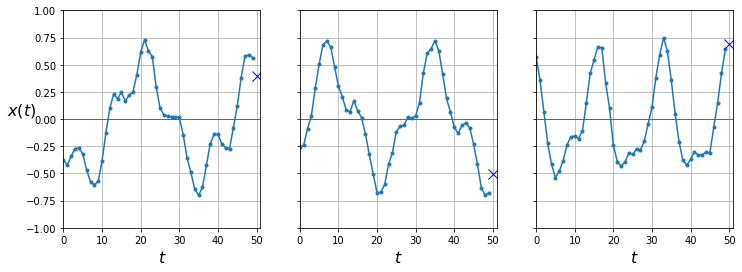

In [4]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
                
plt.show()

In [5]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

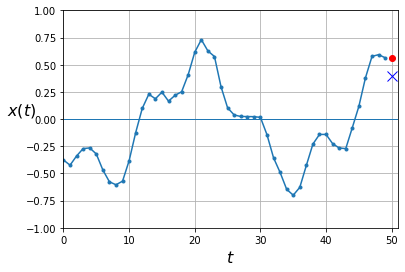

In [6]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [13]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 3ms/step - loss: 0.2437 - val_loss: 0.1018
Epoch 2/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0672 - val_loss: 0.0420
Epoch 3/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0328 - val_loss: 0.0254
Epoch 4/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0220 - val_loss: 0.0191
Epoch 5/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0170 - val_loss: 0.0157
Epoch 6/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0142 - val_loss: 0.0135
Epoch 7/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0125 - val_loss: 0.0120
Epoch 8/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0112 - val_loss: 0.0107
Epoch 9/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0101 - val_loss: 0.0097
Epoch 10/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0091 - val_loss: 0.0088

In [12]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 3ms/step - loss: 0.0037


0.003673766739666462

In [14]:
# 간단한 RNN 구현
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 12s 54ms/step - loss: 0.0228 - val_loss: 0.0114
Epoch 2/20
219/219 [==============================] - 12s 54ms/step - loss: 0.0115 - val_loss: 0.0110
Epoch 3/20
219/219 [==============================] - 12s 55ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 4/20
219/219 [==============================] - 12s 57ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 5/20
219/219 [==============================] - 13s 59ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 6/20
219/219 [==============================] - 12s 57ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 7/20
219/219 [==============================] - 11s 49ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 8/20
219/219 [==============================] - 12s 56ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 9/20
219/219 [==============================] - 12s 54ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 10/20
219/219 [==============================] - 11s 49ms/step - loss: 0.011

In [15]:
# 심층 RNN
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 50s 222ms/step - loss: 0.0274 - val_loss: 0.0100
Epoch 2/20
219/219 [==============================] - 48s 218ms/step - loss: 0.0074 - val_loss: 0.0060
Epoch 3/20
219/219 [==============================] - 49s 223ms/step - loss: 0.0054 - val_loss: 0.0047
Epoch 4/20
219/219 [==============================] - 49s 225ms/step - loss: 0.0046 - val_loss: 0.0041
Epoch 5/20
219/219 [==============================] - 49s 223ms/step - loss: 0.0042 - val_loss: 0.0037
Epoch 6/20
219/219 [==============================] - 53s 244ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 7/20
219/219 [==============================] - 52s 238ms/step - loss: 0.0037 - val_loss: 0.0039
Epoch 8/20
219/219 [==============================] - 54s 248ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 9/20
219/219 [==============================] - 53s 243ms/step - loss: 0.0035 - val_loss: 0.0030
Epoch 10/20
219/219 [==============================] - 52s 236ms/step - l

In [16]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 2s 35ms/step - loss: 0.0027


0.0026580174453556538

In [17]:
# 더 빠르지만 정확도는 비슷한 모델
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 36s 159ms/step - loss: 0.0426 - val_loss: 0.0080
Epoch 2/20
219/219 [==============================] - 34s 155ms/step - loss: 0.0056 - val_loss: 0.0041
Epoch 3/20
219/219 [==============================] - 33s 152ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 4/20
219/219 [==============================] - 33s 150ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 5/20
219/219 [==============================] - 35s 158ms/step - loss: 0.0033 - val_loss: 0.0035
Epoch 6/20
219/219 [==============================] - 34s 158ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 7/20
219/219 [==============================] - 30s 135ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 8/20
219/219 [==============================] - 36s 163ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 9/20
219/219 [==============================] - 34s 157ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 10/20
219/219 [==============================] - 33s 153ms/step - l

In [22]:
'''
There could be several reasons why your RNN training is slower on the GPU compared to the CPU. 
Here are some possibilities:

Batch size: 
GPUs are typically designed to handle large batches of data in parallel. 
If your batch size is too small for the GPU to efficiently parallelize computations, 
it could lead to slower training times.

Model size: 
If your RNN model is small, it's possible that the CPU can handle the computations faster than the GPU. 
GPUs are better suited for larger models with more parameters.

Data transfer: 
While GPUs are faster at performing computations, they can be slower at transferring data to and from the GPU memory. 
If your RNN model has a lot of data movement between the CPU and GPU, it could slow down training.

Software optimization:
Deep learning frameworks like TensorFlow and PyTorch have optimized versions of their libraries for GPUs. 
If your software stack is not optimized for GPU computing, it could lead to slower training times.

GPU hardware: 
It's possible that the GPU you are using is not as powerful as the CPU you are using. 
Not all GPUs are created equal, and some may be better suited for certain types of computations than others.

It's worth noting that while GPUs are generally faster than CPUs for deep learning, 
there are many factors that can impact performance, and it's not always the case that the GPU will be faster. 
It's always a good idea to benchmark your models on both CPUs and GPUs to determine 
which is best suited for your specific use case.

'''
print("CPU를 사용한 학습")
with tf.device("/device:CPU:0"):
    model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)])

    model.compile(loss="mse", optimizer="adam")
    history = model.fit(X_train, y_train, epochs=20,
                        validation_data=(X_valid, y_valid))

CPU를 사용한 학습
Epoch 1/20
219/219 [==============================] - 4s 12ms/step - loss: 0.0401 - val_loss: 0.0050
Epoch 2/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0045 - val_loss: 0.0036
Epoch 3/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 4/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0034 - val_loss: 0.0030
Epoch 5/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 6/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 8/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 9/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 10/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0

In [18]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 23ms/step - loss: 0.0028


0.0027960012666881084

In [31]:
# 여러 타임 스텝 앞을 예측하기
np.random.seed(43)

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

1/1 [==============================] - 0s 87ms/step


In [32]:
Y_pred.shape

(1, 10, 1)

In [33]:
Y_pred

array([[[ 0.6014962 ],
        [ 0.5989326 ],
        [ 0.5168704 ],
        [ 0.37306342],
        [ 0.16003504],
        [-0.06978466],
        [-0.27674806],
        [-0.4166487 ],
        [-0.4874474 ],
        [-0.49761248]]], dtype=float32)

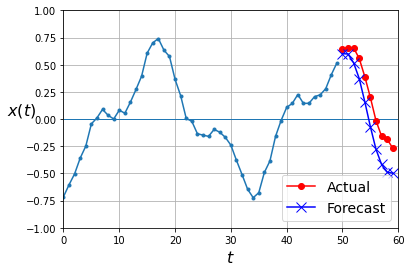

In [34]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14, loc="lower right")

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [35]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [36]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :1]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]
Y_pred.shape

63/63 [==============================] - 6s 97ms/step


(2000, 10)

In [37]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

with tf.device("/device:CPU:0"):
    model.compile(loss="mse", optimizer="adam")
    history = model.fit(X_train, Y_train, epochs=20,
                        validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 10s 44ms/step - loss: 0.0592 - val_loss: 0.0279
Epoch 2/20
219/219 [==============================] - 10s 45ms/step - loss: 0.0238 - val_loss: 0.0176
Epoch 3/20
219/219 [==============================] - 9s 42ms/step - loss: 0.0171 - val_loss: 0.0139
Epoch 4/20
219/219 [==============================] - 9s 43ms/step - loss: 0.0145 - val_loss: 0.0125
Epoch 5/20
219/219 [==============================] - 10s 44ms/step - loss: 0.0130 - val_loss: 0.0117
Epoch 6/20
219/219 [==============================] - 10s 44ms/step - loss: 0.0121 - val_loss: 0.0106
Epoch 7/20
219/219 [==============================] - 10s 45ms/step - loss: 0.0118 - val_loss: 0.0109
Epoch 8/20
219/219 [==============================] - 10s 47ms/step - loss: 0.0112 - val_loss: 0.0095
Epoch 9/20
219/219 [==============================] - 10s 47ms/step - loss: 0.0108 - val_loss: 0.0114
Epoch 10/20
219/219 [==============================] - 10s 48ms/step - loss: 0.0107 

In [38]:
Y_pred = model.predict(X_new)

1/1 [==============================] - 0s 172ms/step


In [39]:
Y_pred

array([[ 0.5549114 ,  0.5576567 ,  0.5245353 ,  0.45615825,  0.34860894,
         0.19972724,  0.06777097, -0.023516  , -0.10337226, -0.19778697]],
      dtype=float32)

In [40]:
from tensorflow.keras.layers import LayerNormalization

In [52]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [55]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [56]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [57]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])
    
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
with tf.device("/device:CPU:0"):
    history = model.fit(X_train, Y_train, epochs=20,
                        validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 16s 67ms/step - loss: 0.1452 - last_time_step_mse: 0.1302 - val_loss: 0.0714 - val_last_time_step_mse: 0.0588
Epoch 2/20
219/219 [==============================] - 15s 67ms/step - loss: 0.0651 - last_time_step_mse: 0.0540 - val_loss: 0.0602 - val_last_time_step_mse: 0.0498
Epoch 3/20
219/219 [==============================] - 15s 69ms/step - loss: 0.0564 - last_time_step_mse: 0.0465 - val_loss: 0.0532 - val_last_time_step_mse: 0.0428
Epoch 4/20
219/219 [==============================] - 15s 70ms/step - loss: 0.0497 - last_time_step_mse: 0.0408 - val_loss: 0.0462 - val_last_time_step_mse: 0.0376
Epoch 5/20
219/219 [==============================] - 16s 71ms/step - loss: 0.0434 - last_time_step_mse: 0.0338 - val_loss: 0.0401 - val_last_time_step_mse: 0.0288
Epoch 6/20
219/219 [==============================] - 16s 72ms/step - loss: 0.0385 - last_time_step_mse: 0.0269 - val_loss: 0.0363 - val_last_time_step_mse: 0.0235
Epoch 7/20
219/2

In [59]:
# 단기 기억 문제 해결하기: LSTM 셀
model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [60]:
model = keras.models.Sequential([
    keras.layers.RNN(keras.layers.LSTMCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(keras.layers.LSTMCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [61]:
# GRU(Gate Recurrent Unit) 셀
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])


model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Epoch 1/20
219/219 [==============================] - 8s 11ms/step - loss: 0.0654 - last_time_step_mse: 0.0580 - val_loss: 0.0455 - val_last_time_step_mse: 0.0375
Epoch 2/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0390 - last_time_step_mse: 0.0317 - val_loss: 0.0348 - val_last_time_step_mse: 0.0275
Epoch 3/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0322 - last_time_step_mse: 0.0234 - val_loss: 0.0303 - val_last_time_step_mse: 0.0211
Epoch 4/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0286 - last_time_step_mse: 0.0186 - val_loss: 0.0271 - val_last_time_step_mse: 0.0170
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0258 - last_time_step_mse: 0.0150 - val_loss: 0.0250 - val_last_time_step_mse: 0.0145
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0239 - last_time_step_mse: 0.0130 - val_loss: 0.0230 - val_last_time_step_mse: 0.0121
Epoch 7/20
219/219 [=======

In [62]:
# WaveNet
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 3s 8ms/step - loss: 0.0654 - last_time_step_mse: 0.0531 - val_loss: 0.0380 - val_last_time_step_mse: 0.0238
Epoch 2/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0340 - last_time_step_mse: 0.0208 - val_loss: 0.0306 - val_last_time_step_mse: 0.0176
Epoch 3/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0289 - last_time_step_mse: 0.0168 - val_loss: 0.0278 - val_last_time_step_mse: 0.0161
Epoch 4/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0263 - last_time_step_mse: 0.0144 - val_loss: 0.0256 - val_last_time_step_mse: 0.0140
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0249 - last_time_step_mse: 0.0132 - val_loss: 0.0245 - val_last_time_step_mse: 0.0130
Epoch 6/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0239 - last_time_step_mse: 0.0121 - val_loss: 0.0233 - val_last_time_step_mse: 0.0113
Epoch 7/20
219/219 [========